In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, MaxPooling2D, BatchNormalization, Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2023-12-20 10:28:56.604131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 10:28:57.224833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Image Specifications
folder_path = "../dataset/MMAFEDB/"
image_dimension = (48, 48)
image_depth = 3
image_color_mode = 'rgb'
batch_size = 512

# Data Augmentation for Training Set
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for Validation Set
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(
    folder_path + "train",
    target_size=image_dimension,
    color_mode=image_color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_set = datagen_val.flow_from_directory(
    folder_path + "valid",
    target_size=image_dimension,
    color_mode=image_color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Get the total number of images in the training set
total_images_train = train_set.n
print("Total images in training set:", total_images_train)
# Get the total number of images in the training set
total_images_test = test_set.n
print("Total images in test set:", total_images_test)

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Total images in training set: 92968
Total images in test set: 17356


In [3]:
drop_rate = 0.3

# Create sequential model
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(48, 48, image_depth), padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(48, 48, image_depth), padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2)) # 48 x 48 -> 24 x 24
model.add(Dropout(drop_rate))

model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2)) # 24 x 24 -> 12 x 12
model.add(Dropout(drop_rate))

model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2)) # 12 x 12 -> 6 x 6
model.add(Dropout(drop_rate))

model.add(Conv2D(512, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1)) # 6 x 6 -> 3 x 3
model.add(Dropout(drop_rate))

# Flatten before fully connected layers
model.add(Flatten())
# Fully Connected Layer + ReLU
model.add(Dense(1024, activation="relu", use_bias=False))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))

# Final Output Layer with Softmax 
model.add(Dense(7,activation='softmax'))

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96)
optimizer_adam = Adam(learning_rate=lr_schedule)

# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

2023-12-20 10:29:00.004281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 10:29:00.029246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 10:29:00.029499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 2847303 (10.86 MB)
Trainable params: 2842503 (10.84 MB)
Non-trainable params: 4800 (18.75 KB)
_________________________________________________________________


In [4]:
# Define hyperparameters
epochs = 100

# Set up model checkpoint
checkpoint = ModelCheckpoint(
    "model_weights2.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
callbacks_list = [checkpoint]

# Train the model
history = model.fit(
    train_set,
    validation_data=test_set,
    steps_per_epoch=total_images_train // batch_size,
    validation_steps=total_images_test // batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/100


2023-12-20 10:29:02.361645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-20 10:29:03.707878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2023-12-20 10:29:05.175716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-20 10:29:05.179074: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55695f6a39c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 10:29:05.179103: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-20 10:29:05.188247: I tensorflow/compiler/mlir/tensorflow/utils/du

181/181 [==============================] - ETA: 0s - loss: 2.2830 - accuracy: 0.2553
Epoch 1: val_accuracy improved from -inf to 0.31700, saving model to model_weights2.h5
181/181 [==============================] - 66s 290ms/step - loss: 2.2830 - accuracy: 0.2553 - val_loss: 1.7915 - val_accuracy: 0.3170
Epoch 2/100


/home/fox/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - ETA: 0s - loss: 1.8943 - accuracy: 0.3537
Epoch 2: val_accuracy improved from 0.31700 to 0.37512, saving model to model_weights2.h5
181/181 [==============================] - 49s 268ms/step - loss: 1.8943 - accuracy: 0.3537 - val_loss: 1.7266 - val_accuracy: 0.3751
Epoch 3/100
181/181 [==============================] - ETA: 0s - loss: 1.7125 - accuracy: 0.4139
Epoch 3: val_accuracy improved from 0.37512 to 0.38725, saving model to model_weights2.h5
181/181 [==============================] - 48s 267ms/step - loss: 1.7125 - accuracy: 0.4139 - val_loss: 1.7199 - val_accuracy: 0.3873
Epoch 4/100
181/181 [==============================] - ETA: 0s - loss: 1.6064 - accuracy: 0.4433
Epoch 4: val_accuracy improved from 0.38725 to 0.41542, saving model to model_weights2.h5
181/181 [==============================] - 49s 269ms/step - loss: 1.6064 - accuracy: 0.4433 - val_loss: 1.5924 - val_accuracy: 0.4154
Epoch 5/100
181/181 [============================

In [5]:
# NOT CHANGED! # DO NOT USE LIKE THIS
model.save_weights("./model2.h5")

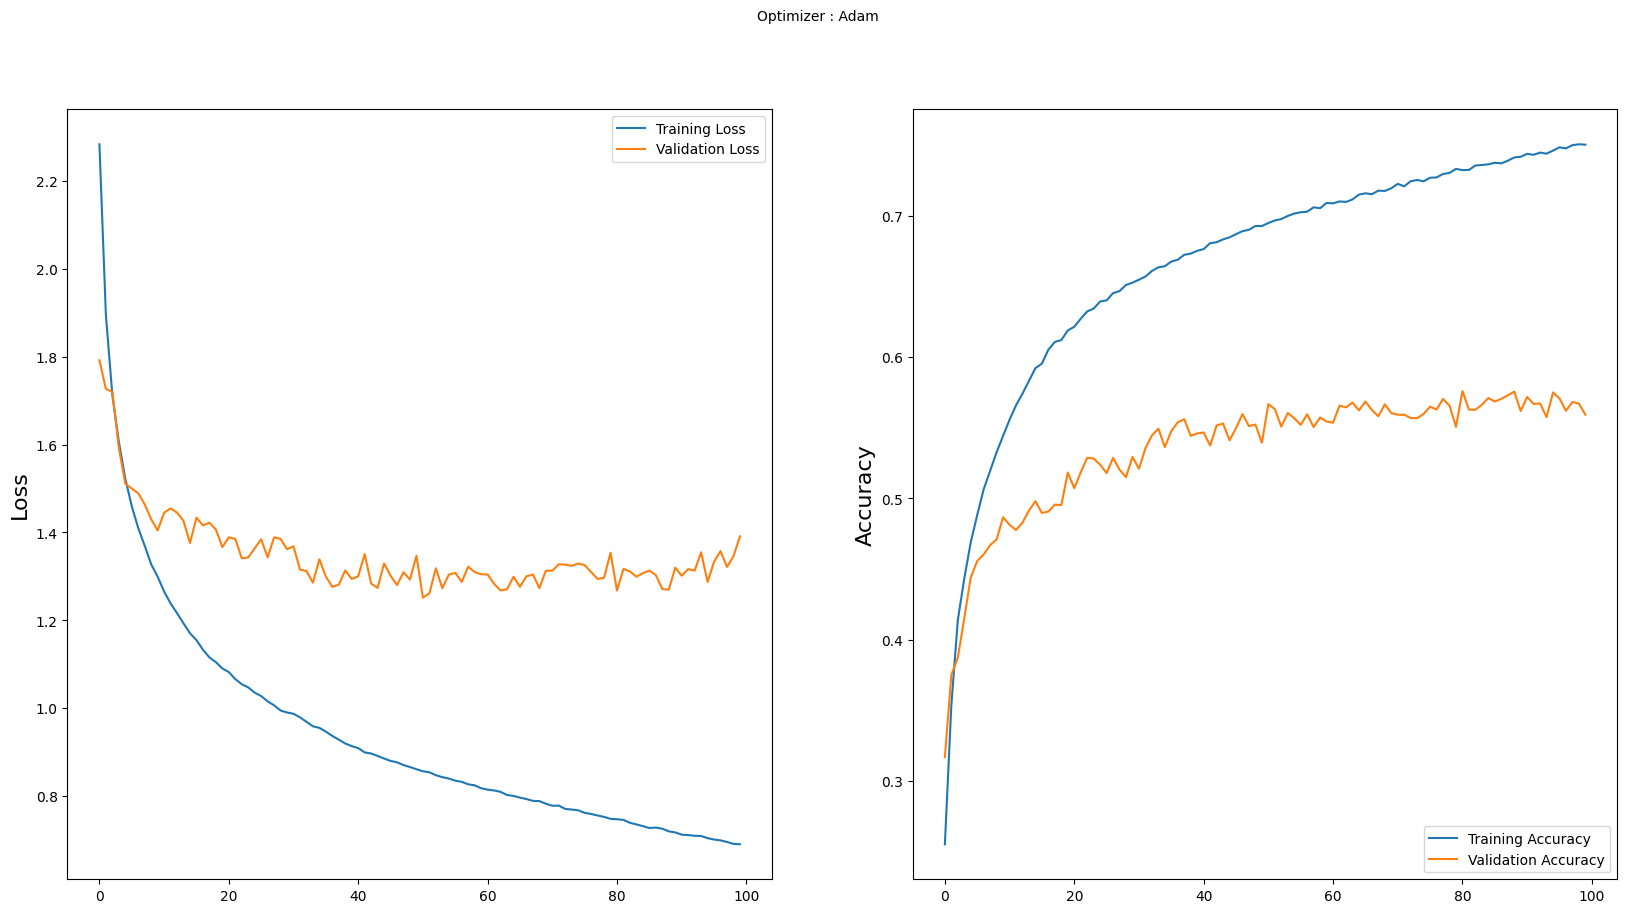

In [6]:
# NOT CHANGED # DO NOT USE LIKE THIS!
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()